# PlantDoc 失败样例分析（E3 模型）

目标：载入 `E3_resnet50_basic_aug_best.pt`，计算验证/测试集混淆矩阵、失败样例，并生成 Grad-CAM 热力图以满足指南第 7.3 和第 9 节要求。

> 运行前请确保已经执行过 `python -m src.training.resnet50_baseline --experiment-name E3_resnet50_basic_aug ...` 并在 `outputs/checkpoints/` 下生成最佳模型。


In [ ]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
except ImportError:
    raise ImportError("请先安装 pytorch-grad-cam：pip install grad-cam")


警告: 使用自定义的 reshape_transform 函数（pytorch-grad-cam 版本可能较旧）


In [43]:
SPLIT_JSON = Path("../data/splits/plantdoc_split_seed42.json")
PROCESSED_ROOT = Path("../data/processed/plantdoc_224")
CHECKPOINT_PATH = Path("../outputs/checkpoints/E3_resnet50_basic_aug_best.pt")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

with SPLIT_JSON.open() as f:
    split_payload = json.load(f)
CLASSES = split_payload["classes"]
class_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}


In [44]:
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class PlantDocEvalDataset(Dataset):
    def __init__(self, split_name, entries):
        self.split_name = split_name
        self.entries = entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        rel = Path(self.entries[idx])
        class_name = rel.parent.name
        img_path = PROCESSED_ROOT / self.split_name / class_name / rel.name
        image = Image.open(img_path).convert("RGB")
        tensor = eval_transform(image)
        label = class_to_idx[class_name]
        return tensor, label, str(rel)


In [45]:
test_dataset = PlantDocEvalDataset("test", split_payload["splits"]["test"])
val_dataset = PlantDocEvalDataset("val", split_payload["splits"]["val"])

def load_model():
    model = torch.hub.load("pytorch/vision:v0.15.2", "resnet50", weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, len(CLASSES))
    state_dict = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    return model.to(DEVICE).eval()

model = load_model()


Using cache found in C:\Users\23208/.cache\torch\hub\pytorch_vision_v0.15.2
C:\Users\23208\AppData\Local\Temp\ipykernel_27888\3152414161.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

In [46]:
def evaluate_split(dataset, split_name="test"):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    preds, labels, rels = [], [], []
    with torch.no_grad():
        for images, y, paths in loader:
            outputs = model(images.to(DEVICE))
            preds.append(outputs.argmax(dim=1).cpu())
            labels.append(y)
            rels.extend(paths)
    preds = torch.cat(preds).numpy()
    labels = torch.cat(labels).numpy()
    return preds, labels, rels

preds_test, labels_test, paths_test = evaluate_split(test_dataset, "test")
preds_val, labels_val, _ = evaluate_split(val_dataset, "val")

print("Test macro-F1", classification_report(labels_test, preds_test, target_names=CLASSES, digits=3))


Test macro-F1                             precision    recall  f1-score   support

           Apple Scab Leaf      0.875     0.500     0.636        14
       Corn Gray leaf spot      0.571     0.364     0.444        11
  Potato leaf early blight      0.583     0.389     0.467        18
   Potato leaf late blight      0.588     0.588     0.588        17
Squash Powdery mildew leaf      0.955     1.000     0.977        21
  Tomato Early blight leaf      0.667     0.267     0.381        15
 Tomato Septoria leaf spot      0.684     0.591     0.634        22
                apple leaf      0.692     0.643     0.667        14
           apple rust leaf      0.857     0.857     0.857        14
          bell pepper leaf      0.700     0.778     0.737         9
     bell pepper leaf spot      0.571     0.400     0.471        10
            blueberry leaf      0.667     0.941     0.780        17
               cherry leaf      0.700     0.778     0.737         9
            corn rust leaf      1

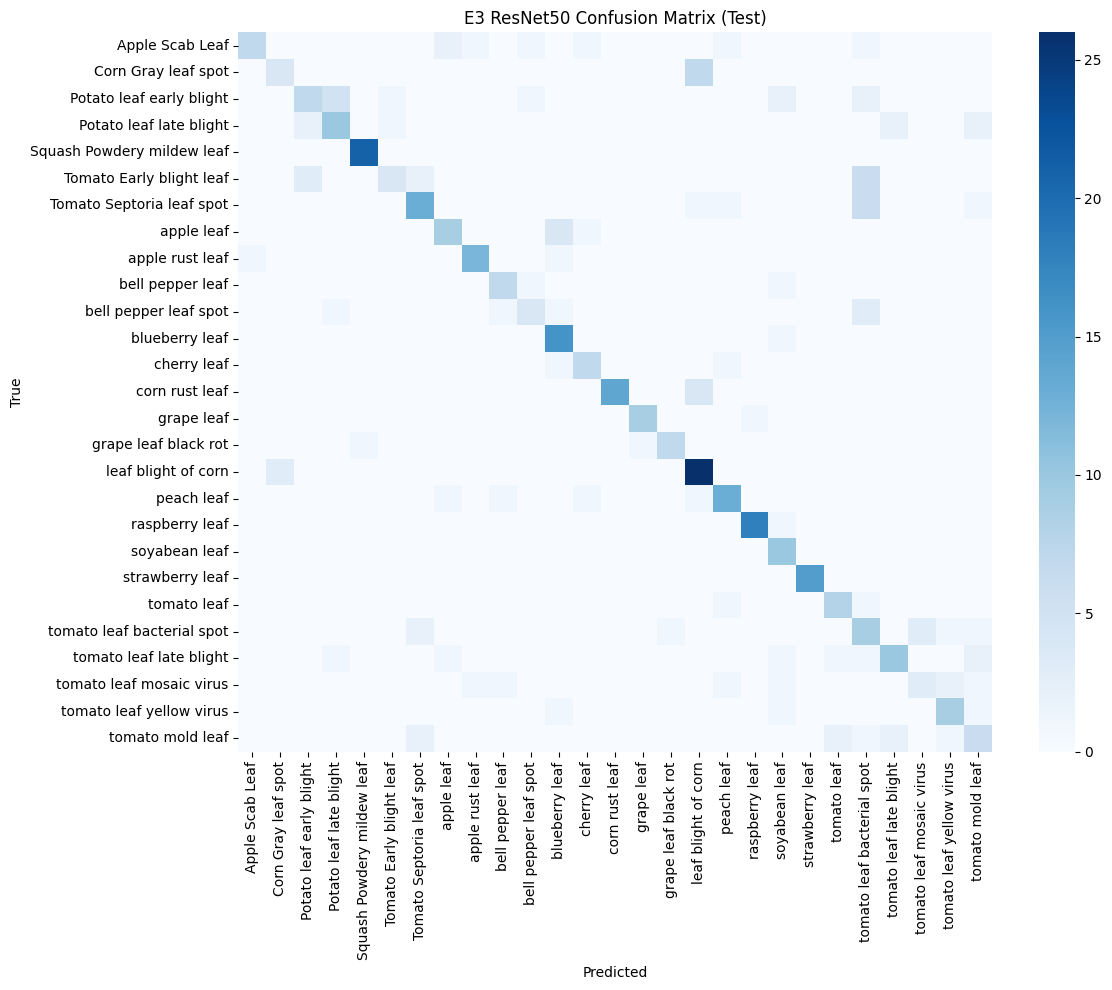

In [47]:
cm = confusion_matrix(labels_test, preds_test)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("E3 ResNet50 Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


In [48]:
confident_errors = []
with torch.no_grad():
    loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    for images, labels, rels in loader:
        outputs = model(images.to(DEVICE))
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)
        for prob, pred, label, rel in zip(probs, preds, labels, rels):
            if pred != label:
                confident_errors.append((prob[pred].item(), CLASSES[label], CLASSES[pred], rel))

confident_errors = sorted(confident_errors, key=lambda x: x[0], reverse=True)
confident_errors[:5]


[(0.9969339370727539,
  'tomato mold leaf',
  'tomato leaf yellow virus',
  'raw\\PlantDoc\\TRAIN\\tomato mold leaf\\tylc.jpg'),
 (0.9826708436012268,
  'blueberry leaf',
  'soyabean leaf',
  'raw\\PlantDoc\\TRAIN\\blueberry leaf\\9167d851305baf06649c57aea130c8fb.jpg'),
 (0.9826176762580872,
  'Potato leaf early blight',
  'Potato leaf late blight',
  'raw\\PlantDoc\\TRAIN\\Potato leaf early blight\\blight-2x.jpg'),
 (0.9825854301452637,
  'Corn Gray leaf spot',
  'leaf blight of corn',
  'raw\\PlantDoc\\TRAIN\\Corn Gray leaf spot\\IMG_5251.jpg'),
 (0.9817761778831482,
  'Potato leaf early blight',
  'Potato leaf late blight',
  'raw\\PlantDoc\\TRAIN\\Potato leaf early blight\\21-late%20blight-early%20symptoms%20potato.jpg')]

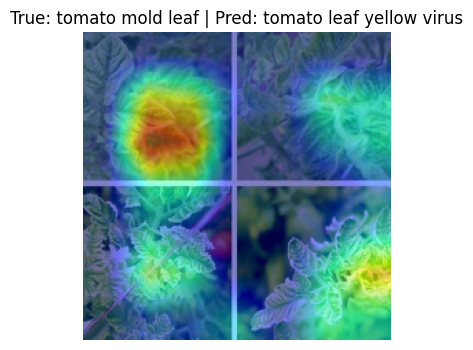

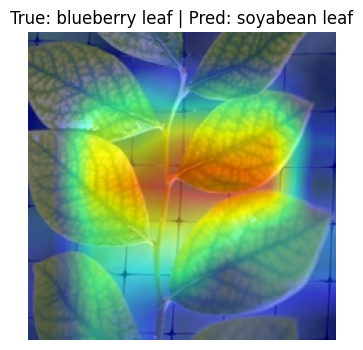

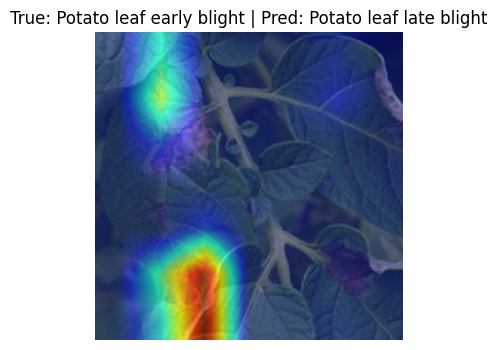

In [52]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

def show_failure(entry):
    _, true_label, pred_label, rel = entry
    rel = Path(rel)
    class_name = rel.parent.name
    img_path = PROCESSED_ROOT / "test" / class_name / rel.name
    rgb = Image.open(img_path).convert("RGB")
    input_tensor = eval_transform(rgb).unsqueeze(0).to(DEVICE)
    targets = [ClassifierOutputTarget(class_to_idx[pred_label])]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    rgb_norm = np.array(rgb).astype(np.float32) / 255.0
    visualization = show_cam_on_image(rgb_norm, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(6, 4))
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.imshow(visualization)
    plt.axis("off")
    plt.show()

for entry in confident_errors[:3]:
    show_failure(entry)
